Wahlpflichtfach Künstliche Intelligenz II: Testat 

---

# 01 - Testat zu Tensorflow (Regression)
__Gruppennummer:__ 1

__Mitglieder:__
- Lena Awe
- Leni Lakebrink
- Jannes Teupen
- Lucas Weihermann
- Jakob Zoll

In [65]:
%matplotlib inline

## Data Understanding
Laden Sie die Daten und machen Sie sich mit ihnen vertraut. Den Datensatz finden Sie unter folgendem [Link](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset).

In [1]:
import pandas as pd

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)
df = pd.DataFrame(data=data.data, columns=data.feature_names)
df["target"] = data.target
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [67]:
# import seaborn as sns

# sns.set_theme(style="whitegrid")
# sns.pairplot(df, hue="target")

## Data Preperation (2 Punkte)
Die erste Aufgabe ist es den Datensatz fürs maschinelle Lernen vorzubereiten. Dazu sind die folgenden Schritte nötig:
* a) Auswahl der Strategie(n) zum Ersetzen der fehlenden Werte und anschließenden skalieren dieser
* b) Erstellen der Preparation-Pipeline

_Hinweise/Tipps:_
* Sie müssen die unterschiedlichen Algorithmen nicht (bis zum Maximum) optimieren, hier geht es gerade eher darum zu überprüfen, ob Sie die Algorithmen generell verstanden haben und Sie richtig einsetzen/kombinieren können.
* Gucken Sie sich nochmal die besprochenen Algorithmen aus dem Praktikum 1 an und überlegen wo die Stärken und Schwächen liegen.
* Sie können selbstverständlich auch unterschiedliche Methoden für die einzelnen Merkmale wählen.

### a) Auswahl der Strategie(n)
_Punkte: 1_

Als erstes müssen Sie sich eine Strategie zum Ersetzen der fehlenden Werte überlegen. Beschreiben Sie diese in der nachfolgenden Markdown-Zeile und begründen Sie, warum Sie diese Strategie gewählt haben. Außerdem sollten die Daten skaliert/normalisiert werden. Beschreiben Sie Ihre Strategie und begründen Sie, warum Sie diese Strategie bzw. Methoden gewählt haben. Erstellen sie zusätzlich einen Test und Trainingsdatensatz

**Ihre Antwort:**

Da es keine fehlenden Werte gibt, müssen keine Werte ersetzt werden. Wenn es fehlende Werte gegeben hätte, hätten wir diese mit dem IterativeImputer ersetzt, da sowohl auf Zeilen- wie auch auf Spalten-Ebene ein Zusammenhang zwischen den Daten besteht.

Für die Skalierung der Werte nutzen wir einen RobustScaler, damit Ausreißer die Ergebnisse nicht zu stark beeinflussen. Damit skalieren wir alle Werte bis auf Ausreißer auf einen Wertebreich von -1 bis 1. Alle Spalten bis auf die Zielvariable werden skaliert, da nur metrische Variablen vorliegen. 

Da wir nur die Skalierung verwenden, wird keine Pipeline benötigt. 

### b) Erstellen der Preparation-Pipeline
_Punkte: 1_

In [2]:
from sklearn.preprocessing import RobustScaler
import torch

data_scaled = RobustScaler().fit_transform(df.drop(columns=['target']))
target = df['target']

n = len(data_scaled)
input_dim = data_scaled.shape[1]
x = torch.tensor(data_scaled, dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32).view(-1, 1)


## Modeling (3 Punkte)
Ihre nächste Aufgabe ist es das Training vorzubereiten und den richtigen ML-Algorithmus auszuwählen. Dafür müssen Sie die folgenden Teilaufgaben erledigen:
* a) Erstellen sie ein Multilayer Perceptron
* b) Entscheiden sie sich für eine Loss-Funktion, Optimierer und geeignete Metriken. Zusätzlich erstellen sie ein Tensorboard.
* c) Trainieren sie das neuronale Netz

### a) Erstellen sie ein Multilayer Perceptron
_Punkte: 1,5_

Denken sie an die Initialisierung der Gewichte im Layer sowie die Wahl der Aktivierungsfunktion


In [3]:
from datetime import datetime

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f'./data/01_testat_nn/runs/run_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

ids = torch.randperm(len(x))
train_ids = ids[:int(n * .6)]
val_ids = ids[int(n * .6):int(n * .8)]
test_ids = ids[int(n * .8):]

train_dataset = TensorDataset(x[train_ids], y[train_ids])
val_dataset = TensorDataset(x[val_ids], y[val_ids])
test_dataset = TensorDataset(x[test_ids], y[test_ids])

batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True  # Shuffle training data each epoch
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle validation
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle test
)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 387
Validation batches: 129
Test batches: 129


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

model = RegressionMLP(input_dim=input_dim)

# Log the model architecture to TensorBoard
writer.add_graph(model, x[train_ids][:batch_size])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model Architecture:
RegressionMLP(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 2,689
Trainable parameters: 2,689


### b) Loss-Funktion, Optimierer und Metriken
_Punkte: 1_

In [6]:
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # sollen wir standardmäßig als Optimizer verwenden
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Reduce LR when validation loss stops decreasing
    factor=0.5,      # Multiply LR by 0.5
    patience=10,     # Wait 10 epochs before reducing
)

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()  # Set model to training mode
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
    
    return train_loss / len(train_loader.dataset)  # Return average loss

def validate(model, val_loader, criterion):
    """Validate the model"""
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    return val_loss / len(val_loader.dataset)

def compute_metrics(model, data_loader):
    """Compute detailed regression metrics"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            predictions = model(batch_X)
            all_predictions.append(predictions)
            all_targets.append(batch_y)
    
    predictions = torch.cat(all_predictions, dim=0)
    targets = torch.cat(all_targets, dim=0)
    
    mse = F.mse_loss(predictions, targets).item()        
    return {
        'mse': mse,                                     # Mean Squared Error (MSE)
        'rmse': np.sqrt(mse),                           # Root Mean Squared Error (RMSE)
        'mae': F.l1_loss(predictions, targets).item(),  # Mean Absolute Error (MAE)
    }

#### c) Trainieren des neuronale Netz
_Punkte: 0,5_

In [10]:
# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 20

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalars('Loss/Train_vs_Val', {'Train': train_loss, 'Validation': val_loss}, epoch)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), './data/01_testat_nn/model.pth')  # Save best model
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:7.4f} | "
              f"Val Loss: {val_loss:7.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

writer.close()

Epoch   1/100 | Train Loss:  0.3240 | Val Loss:  0.3374 | LR: 0.000250
Epoch  10/100 | Train Loss:  0.7032 | Val Loss:  0.5808 | LR: 0.000250
Epoch  20/100 | Train Loss:  0.3155 | Val Loss:  0.3330 | LR: 0.000125
Epoch  30/100 | Train Loss:  0.8006 | Val Loss:  0.4828 | LR: 0.000125
Epoch  40/100 | Train Loss:  0.3117 | Val Loss:  0.3282 | LR: 0.000063
Epoch  50/100 | Train Loss:  0.3140 | Val Loss:  0.3441 | LR: 0.000063
Epoch  60/100 | Train Loss:  0.3082 | Val Loss:  0.3272 | LR: 0.000031
Epoch  70/100 | Train Loss:  0.3089 | Val Loss:  0.3272 | LR: 0.000031
Epoch  80/100 | Train Loss:  0.3134 | Val Loss:  0.3302 | LR: 0.000016
Epoch  90/100 | Train Loss:  0.3044 | Val Loss:  0.3260 | LR: 0.000016
Epoch 100/100 | Train Loss:  0.3039 | Val Loss:  0.3260 | LR: 0.000016


## Evaluation (2 Punkte)
Verwenden sie die Metriken sowie für das Problem geeignete Visualisierungen und erläutern sie ihre Ergebnisse.

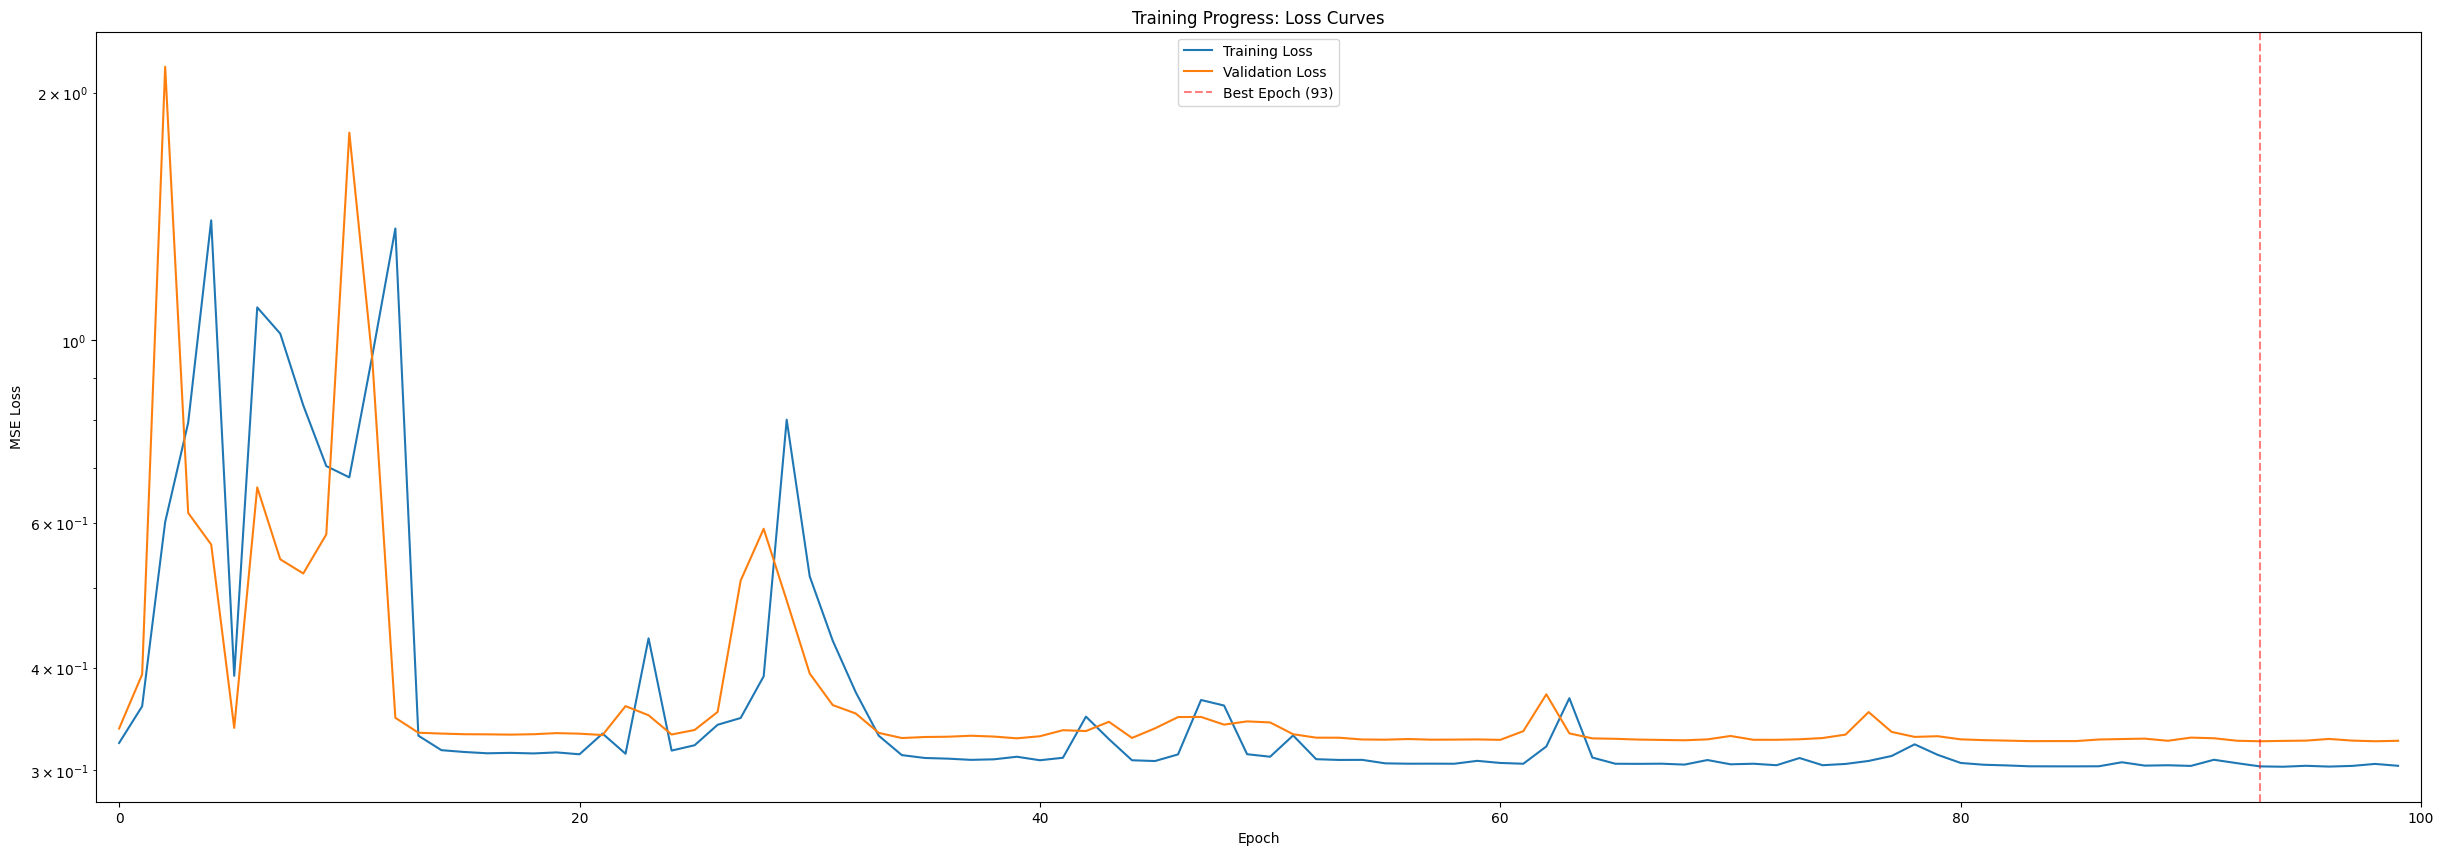

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set(xlabel='Epoch', ylabel='MSE Loss', title='Training Progress: Loss Curves', yscale='log', xlim=(-1, len(train_losses)))

# Mark best epoch
best_epoch = np.argmin(val_losses)
ax.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')

ax.legend()

In [ ]:
model.load_state_dict(torch.load('./data/01_testat_nn/model.pth'))

train_metrics = compute_metrics(model, train_loader)
val_metrics = compute_metrics(model, val_loader)
test_metrics = compute_metrics(model, test_loader)  # Compute test metrics
print(f"MSE:  {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f} (± ${test_metrics['rmse']:.2f}ht average error)")
print(f"MAE:  {test_metrics['mae']:.4f} (${test_metrics['mae']:.2f}ht average error)")

MSE:  0.3463
RMSE: 0.5885 (± $0.59hundredthousand average error)
MAE:  0.4084 ($0.41hundredthousand average error)


In [13]:
y[test_ids].flatten().shape, model(x[test_ids]).flatten().shape

(torch.Size([4128]), torch.Size([4128]))

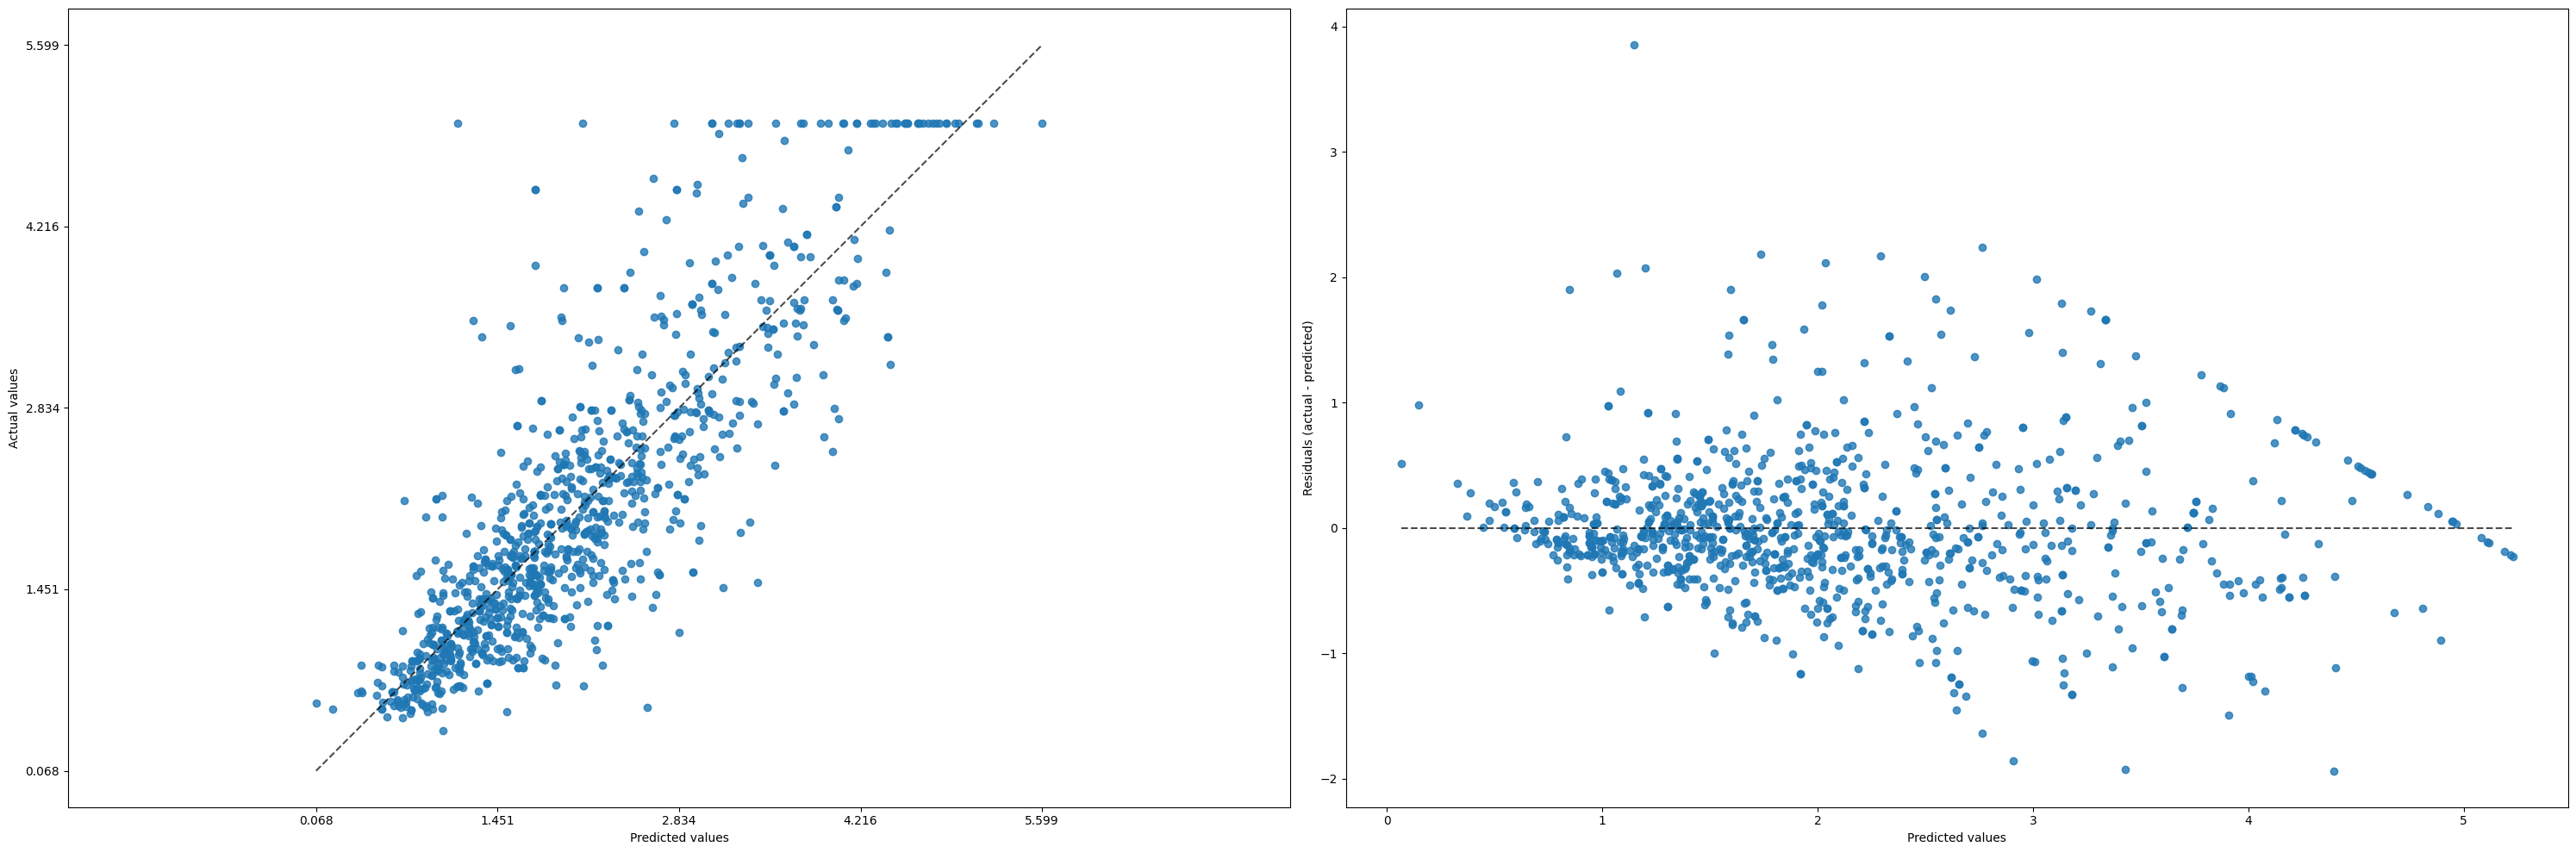

In [14]:
from sklearn.metrics import PredictionErrorDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

y_true = y[test_ids].numpy().ravel()
y_pred = model(x[test_ids]).detach().numpy().ravel()

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    ax=ax1,
    kind='actual_vs_predicted',
)
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind='residual_vs_predicted',
    ax=ax2,
)
fig.tight_layout()

## Hyperparameteroptimierung (3 Punkte)

Führen sie eine Hyperparameteroptimierung mit dem Keras-Tuner durch. Anschließend sollen Sie das beste Modell erneut evaluieren und die Veränderung zum vorherigen Begründen.
* a) Hyperparameteroptimierung
* b) Evaluation

### Hyperparameteroptimierung
_Punkte: 2_

In [15]:
import torch.nn as nn

class FlexibleClassifier(nn.Module):
    """
    Flexible neural network that can be configured with different architectures.
    Supports variable depth and layer dimensions.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate):
        """
        Args:
            input_dim: Number of input features
            hidden_dims: List of hidden layer dimensions, e.g., [64, 32]
            output_dim: Number of output classes
            dropout_rate: Dropout probability
        """
        super().__init__()
        
        # Build layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [16]:
import optuna

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def evaluate(model, data_loader, criterion):
    """Evaluate the model"""
    model.eval()
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            eval_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = eval_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, num_epochs=100, lr=0.01, weight_decay=0.0, patience=15, trial=None):
    """Complete training loop"""
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer) # Train
        val_loss, val_acc = evaluate(model, val_loader, criterion)  # Validate
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
        if trial is not None:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()
    
    return best_val_loss, best_epoch

In [17]:
def objective(trial):
    """
    Objective function for Optuna to optimize.
    Returns the best validation accuracy for this hyperparameter configuration.
    """
    # Define the search space
    n_layers = trial.suggest_int('n_layers', 1, 2)
    hidden_dims = []
    for i in range(n_layers):
        dim = trial.suggest_categorical(f'hidden_dim_layer_{i}', [32, 64, 128, 256])
        hidden_dims.append(dim)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)    
    
    # Training the model with the sampled hyperparameters
    model = FlexibleClassifier(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=1,dropout_rate=dropout_rate)        
    best_val_acc, _ = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=learning_rate,
        weight_decay=weight_decay,
        trial=trial  # For Optuna pruning
    )
    
    return best_val_acc

In [18]:
study = optuna.create_study(
    direction='minimize',
    study_name='housing_regression',
    pruner=optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10
    )
)

n_trials = 50
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2026-02-21 09:22:14,438] A new study created in memory with name: diabetes_classification


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2026-02-21 09:23:38,541] Trial 0 finished with value: 0.2965422971535099 and parameters: {'n_layers': 2, 'hidden_dim_layer_0': 256, 'hidden_dim_layer_1': 64, 'weight_decay': 0.0009648612328537194, 'learning_rate': 0.0005782370113691893, 'dropout_rate': 0.35076559219390185}. Best is trial 0 with value: 0.2965422971535099.
[I 2026-02-21 09:23:51,324] Trial 1 finished with value: 4.876558922982031 and parameters: {'n_layers': 1, 'hidden_dim_layer_0': 128, 'weight_decay': 0.00015692690662043765, 'learning_rate': 0.011222743714889665, 'dropout_rate': 0.11257624728485555}. Best is trial 0 with value: 0.2965422971535099.
[I 2026-02-21 09:24:08,799] Trial 2 finished with value: 0.4033924664637839 and parameters: {'n_layers': 2, 'hidden_dim_layer_0': 32, 'hidden_dim_layer_1': 256, 'weight_decay': 0.00011452022042418679, 'learning_rate': 0.0057299092015038345, 'dropout_rate': 0.4111913747081463}. Best is trial 0 with value: 0.2965422971535099.
[I 2026-02-21 09:25:18,929] Trial 3 finished with

In [19]:
best_params = study.best_trial.params

n_layers = best_params['n_layers']
hidden_dims = [best_params[f'hidden_dim_layer_{i}'] for i in range(n_layers)]

best_model = FlexibleClassifier(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=1,
    dropout_rate=best_params['dropout_rate']
)

best_val_loss, _ = train_model(
    model=best_model,
    train_loader=train_loader,
    val_loader=val_loader,
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay'],
)

print(f"  Lowest validation loss: {best_val_loss:.4f}")

  Lowest validation loss: 0.2687


### Evaluation
_Punkte: 1_

Erläutern sie den unterschied zwischen den beiden Modellen und den Einfluss auf die von Ihnen gemessenen Werte

**Ihre Antwort:**

# TODO 

In [20]:
%load_ext tensorboard
%tensorboard --host 0.0.0.0 --port=8080  --logdir=./data/01_testat_nn/runs 

---

Wahlpflichtach Künstliche Intelligenz II: Testat 